<a href="https://colab.research.google.com/github/MicroprocessorX069/Stroke-Prediction-/blob/master/Base_Feed_Forward_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive/')
 

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import os
# from classes3 import  FeedForwardNN
import torch.nn as nn
import torch.nn.functional as F
import os
from datetime import datetime
# import visdom

In [4]:
path="/content/drive/My Drive/StrokePrediction/data/healthcare-dataset-stroke-data"
data= pd.read_csv(os.path.join(path,"train_2v.csv")).dropna()
data.shape

(29072, 12)

In [5]:
data['Weights'] = np.where(data['stroke'] == 1, 0.9, .004)
data['Weights'].unique()

val_data=data.sample(frac=0.05, random_state=123, weights='Weights')
#train_data = data.loc[~data.index.isin(val_data.index)]
print(len(np.where(val_data['stroke']==1)[0]),len(np.where(val_data['stroke']==0)[0]))
data_org=data

548 906


In [0]:
from torch.utils.data import Dataset, DataLoader


class TabularDataset2(Dataset):
  def __init__(self, data, cat_cols=None, output_col=None):
    """
    Characterizes a Dataset for PyTorch

    Parameters
    ----------

    data: pandas data frame
      The data frame object for the input data. It must
      contain all the continuous, categorical and the
      output columns to be used.

    cat_cols: List of strings
      The names of the categorical columns in the data.
      These columns will be passed through the embedding
      layers in the model. These columns must be
      label encoded beforehand. 

    output_col: string
      The name of the output variable column in the data
      provided.
    """

    self.n = data.shape[0]

    if output_col:
      self.y = data[output_col].astype(np.float32).values.reshape(-1, 1)
    else:
      self.y =  np.zeros((self.n, 1))

    self.cat_cols = cat_cols if cat_cols else []
    self.cont_cols = [col for col in data.columns
                      if col not in self.cat_cols + [output_col]]

    if self.cont_cols:
      self.cont_X = data[self.cont_cols].astype(np.float32).values
    else:
      self.cont_X = np.zeros((self.n, 1))

    if self.cat_cols:
      self.cat_X = data[cat_cols].astype(np.int64).values
    else:
      self.cat_X =  np.zeros((self.n, 1))

  def __len__(self):
    """
    Denotes the total number of samples.
    """
    return self.n

  def __getitem__(self, idx):
    """
    Generates one sample of data.
    """
    return [self.y[idx], self.cont_X[idx], self.cat_X[idx]]
  

  
  
class FeedForwardNN(nn.Module):
  def __init__(self,emb_dims,no_of_cont, lin_layer_sizes,
              output_size,emb_dropout, lin_layer_dropouts):
    '''
    #emb_dims: list of two tuples
    #tuple1: no. of unqie values for that categorical variable
    #tuple 2: shape of that features data
    
    #no_of_cont: number of continuous features
    
    lin_layer_sizes: list of integers
    no. of nodes in each linear layer in the network
    
    output_size=Integer
    size of final output
    
    emb_dropout: float
    dropout used after embedding layers
    
    lin_layer_dropouts: 
    dropout after each linear layer
    
    '''
    super().__init__()

    # Embedding layers
    self.emb_layers = nn.ModuleList([nn.Embedding(x, y)
                                     for x, y in emb_dims])

    no_of_embs = sum([y for x, y in emb_dims])
    self.no_of_embs = no_of_embs
    self.no_of_cont = no_of_cont

    # Linear Layers
    first_lin_layer = nn.Linear(self.no_of_embs + self.no_of_cont,
                                lin_layer_sizes[0])

    self.lin_layers =\
     nn.ModuleList([first_lin_layer] +\
          [nn.Linear(lin_layer_sizes[i], lin_layer_sizes[i + 1])
           for i in range(len(lin_layer_sizes) - 1)])
    
    for lin_layer in self.lin_layers:
      nn.init.kaiming_normal_(lin_layer.weight.data)

    # Output Layer
    self.output_layer = nn.Sequential(nn.Linear(lin_layer_sizes[-1],
                                  output_size),nn.Sigmoid())
    #nn.init.kaiming_normal_(self.output_layer.weight.data)

    # Batch Norm Layers
    self.first_bn_layer = nn.BatchNorm1d(self.no_of_cont)
    self.bn_layers = nn.ModuleList([nn.BatchNorm1d(size)
                                    for size in lin_layer_sizes])

    # Dropout Layers
    self.emb_dropout_layer = nn.Dropout(emb_dropout)
    self.droput_layers = nn.ModuleList([nn.Dropout(size)
                                  for size in lin_layer_dropouts])

  def forward(self,cont_data,cat_data):
    if self.no_of_embs != 0:
      x = [emb_layer(cat_data[:, i])
           for i,emb_layer in enumerate(self.emb_layers)]
      x = torch.cat(x, 1)
      x = self.emb_dropout_layer(x)

    if self.no_of_cont != 0:
      normalized_cont_data = self.first_bn_layer(cont_data)

      if self.no_of_embs != 0:
        x = torch.cat([x, normalized_cont_data], 1) 
      else:
        x = normalized_cont_data

    for lin_layer, dropout_layer, bn_layer in\
        zip(self.lin_layers, self.droput_layers, self.bn_layers):
      
      x = F.relu(lin_layer(x))
      x = bn_layer(x)
      x = dropout_layer(x)
    
    x = self.output_layer(x)
    
    return x
  
  
  


##Analysis

In [7]:
data.stroke.value_counts()


0    28524
1      548
Name: stroke, dtype: int64

##Features segregation

In [0]:
categorical_features=["gender","hypertension","heart_disease",
                      "ever_married","work_type","Residence_type",
                     "smoking_status"]
output_feature="stroke"

from sklearn.preprocessing import LabelEncoder
label_encoders={}
for cat_col in categorical_features:
  label_encoders[cat_col]=LabelEncoder()
  data[cat_col]=label_encoders[cat_col].fit_transform(data[cat_col])


In [0]:
data=data.drop("Weights",axis=1)
data_org=data
data=data.drop("id",axis=1)

##Creating object of class 'Tabular Dataset'

In [10]:
dataset=TabularDataset2(data=data,cat_cols=categorical_features,
                      output_col=output_feature)
dataset[0]

[array([0.], dtype=float32),
 array([58.  , 87.96, 39.2 ], dtype=float32),
 array([1, 1, 0, 1, 2, 1, 1])]

##Parameters

In [0]:
batchsize=800
dataloader=DataLoader(dataset,batchsize,shuffle=True,num_workers=1)

##Getting the dimensions for embeddings

In [12]:
cat_dims=[int(data[col].nunique()) for col in categorical_features] #no of unique values for each categorical variable
emb_dims=[(x,min(128,(x+1)//2)) for x in cat_dims] #reducing the embedding to half size.
emb_dims

[(3, 2), (2, 1), (2, 1), (2, 1), (5, 3), (2, 1), (3, 2)]

##Creating an instance of model

In [0]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Hyper parameters
no_of_cont=3 #no of continuous variables 
lin_layer_sizes=[128,64]
output_size=1
emb_dropout=0.04
lin_layer_dropouts=[0.001,0.01]
model= FeedForwardNN(emb_dims, no_of_cont, lin_layer_sizes,
                    output_size, emb_dropout,
                    lin_layer_dropouts).to(device)

##Training

In [23]:
# vis = Visualizations()

no_of_epochs = 5000
# criterion = nn.BCEWithLogitsLoss()
# criterion=nn.MSELoss()
criterion=nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

loss_values = []
for epoch in range(no_of_epochs):
      i=0
      
      
      for y, cont_x, cat_x in dataloader:
        i+=200
        cat_x = cat_x.to(device)
        cont_x = cont_x.to(device)
        y  = y.to(device)

        # Forward Pass
        preds = model(cont_x, cat_x)
                
        loss = criterion(preds, y)

        # Backward Pass and Optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        if(i==200):
          print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                .format(epoch+1, no_of_epochs, i+1, batchsize, loss.item()))
          
      loss_values.append(loss)


Epoch [1/5000], Step [201/1454], Loss: 0.7047
Epoch [2/5000], Step [201/1454], Loss: 0.0938
Epoch [3/5000], Step [201/1454], Loss: 0.0770
Epoch [4/5000], Step [201/1454], Loss: 0.0963
Epoch [5/5000], Step [201/1454], Loss: 0.0767
Epoch [6/5000], Step [201/1454], Loss: 0.0751
Epoch [7/5000], Step [201/1454], Loss: 0.0907
Epoch [8/5000], Step [201/1454], Loss: 0.0710
Epoch [9/5000], Step [201/1454], Loss: 0.0607
Epoch [10/5000], Step [201/1454], Loss: 0.0877
Epoch [11/5000], Step [201/1454], Loss: 0.0750
Epoch [12/5000], Step [201/1454], Loss: 0.0746
Epoch [13/5000], Step [201/1454], Loss: 0.0848
Epoch [14/5000], Step [201/1454], Loss: 0.0807
Epoch [15/5000], Step [201/1454], Loss: 0.0743
Epoch [16/5000], Step [201/1454], Loss: 0.1045
Epoch [17/5000], Step [201/1454], Loss: 0.0466
Epoch [18/5000], Step [201/1454], Loss: 0.0589
Epoch [19/5000], Step [201/1454], Loss: 0.0755
Epoch [20/5000], Step [201/1454], Loss: 0.0717
Epoch [21/5000], Step [201/1454], Loss: 0.0586
Epoch [22/5000], Step 

KeyboardInterrupt: ignored

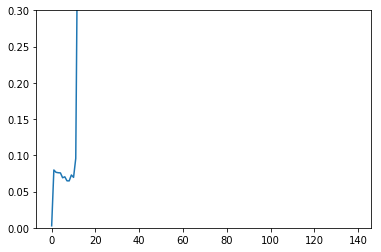

In [24]:
import matplotlib.pyplot as plt

temp=0
batch=20
avg_loss_values=[]
for i,loss in enumerate(loss_values):
  temp+=loss
  if i%batch==0:
    avg_loss_values.append(temp/batch)
    temp=0
   
plt.plot(avg_loss_values)
plt.ylim((0,0.3))
plt.show()    

In [0]:
model.modules

##Setting up Test Loader

In [0]:

label_encoders={}
for cat_col in categorical_features:
  label_encoders[cat_col]=LabelEncoder()
  val_data[cat_col]=label_encoders[cat_col].fit_transform(val_data[cat_col])
  
val_data=val_data.drop("Weights",axis=1)
val_data_org=val_data
val_data=val_data.drop("id",axis=1)

val_dataset=TabularDataset2(data=val_data,cat_cols=categorical_features,
                      output_col=output_feature)
val_dataset[0]



In [0]:
batchsize=1454
val_dataloader=DataLoader(val_dataset,batchsize,shuffle=False)


In [26]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
prec_values,rec_values,f1_values=[],[],[]

with torch.no_grad():
  loss,i=0,0
  
  for y, cont_x, cat_x in val_dataloader:
    cat_x = cat_x.to(device)
    cont_x = cont_x.to(device)
    y  = y.to(device)
    preds=model(cont_x, cat_x)
    #preds=torch.round(preds)
#     print(y[:5])
    loss+=criterion(preds,y)
    i+=1
    y = y.cpu()
    preds = preds.cpu()
    precision,recall,fscore,_=precision_recall_fscore_support(y, torch.round(preds), average='macro')
    prec_values.append(precision)
    rec_values.append(recall)
    f1_values.append(fscore)

  print('Loss of the model: {} '.format( loss / i))
torch.save(model.state_dict(),'model.ckpt')

Loss of the model: 10.413891792297363 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
# import scikitplot as skplt
# y_true = np.array(['cat', 'dog', 'pig', 'cat', 'dog', 'pig'])
# y_pred = np.array(['cat', 'pig', 'dog', 'cat', 'cat', 'dog'])

# print (y)
# print (preds)

y_true = y.tolist()
y_pred = torch.round(preds).tolist()
print (precision_recall_fscore_support(y_true, y_pred, average='macro'))

print (accuracy_score(y_true, y_pred))
print ("Accuracy:",accuracy_score(y_true, y_pred, normalize=False))

from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_true, y_pred)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

# skplt.metrics.plot_roc_curve(y_true, y_pred)
# plt.show()